In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model_loss_train_ver2 import *
from model.final_model_ver2 import PatientOutcomeModel
from model.autoencoder_v3_lstm import  TSAutoencoder

import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()



In [2]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses_level.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)

# ## load the inbalanced dataset sampler
# labels_train = [int(dataset_train[i][5]) for i in range(len(dataset_train))]
# labels_val = [int(dataset_val[i][5]) for i in range(len(dataset_val))]
# labels_test = [int(dataset_test[i][5]) for i in range(len(dataset_test))]

# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_train)
# val_sampler = ImbalancedDatasetSampler(dataset_val, labels=labels_val)
# test_sampler = ImbalancedDatasetSampler(dataset_test, labels=labels_test)

## build the dataloader
# train_loader = DataLoader( dataset_train,batch_size=16,sampler=train_sampler,collate_fn=collate_fn )
# val_loader = DataLoader( dataset_val,batch_size=16,sampler=val_sampler,collate_fn=collate_fn)
# test_loader = DataLoader( dataset_test,batch_size=16,sampler=test_sampler,collate_fn=collate_fn )
train_loader = DataLoader( dataset_train,batch_size=16,shuffle=True,collate_fn=collate_fn )
val_loader = DataLoader( dataset_val,batch_size=16,shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader( dataset_test,batch_size=16,shuffle=False,collate_fn=collate_fn )
train_loader_p = DataLoader(dataset_train, batch_size=16, shuffle=False, collate_fn=collate_fn)


Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [ ]:
# from torch.utils.data import Subset


# train_loader = DataLoader( dataset_train,batch_size=16,shuffle=False,collate_fn=collate_fn )

# batch = next(iter(train_loader))
# *_, original_indices = batch
# small_ids = original_indices.tolist()

# small_subset = Subset(dataset_train, small_ids)

# small_train_loader = DataLoader(
#     small_subset,
#     batch_size=len(small_ids),
#     shuffle=True,
#     collate_fn=collate_fn
# )
# small_train_loader_p = DataLoader(
#     small_subset,
#     batch_size=len(small_ids),
#     shuffle=False,
#     collate_fn=collate_fn
# )

In [3]:

flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load("/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage3/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [4]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_v2"

model, history = train_patient_outcome_model(model, 
            val_loader, val_loader, train_loader_p, device, optimizer,  epochs=100, save_dir=save_path, 
            theta=1, gamma=50, kappa=1, beta=10, eta=1,
            patience = 20, update_P_every_n_epochs = 10 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 3126284
[Joint] Calculating  patient_start_offset_global (once before training)...


[Joint]  patient_start_offset_global calculated. Shape: torch.Size([2150])


IndexError: The shape of the mask [49856] at index 0 does not match the shape of the indexed tensor [7620, 100] at index 0

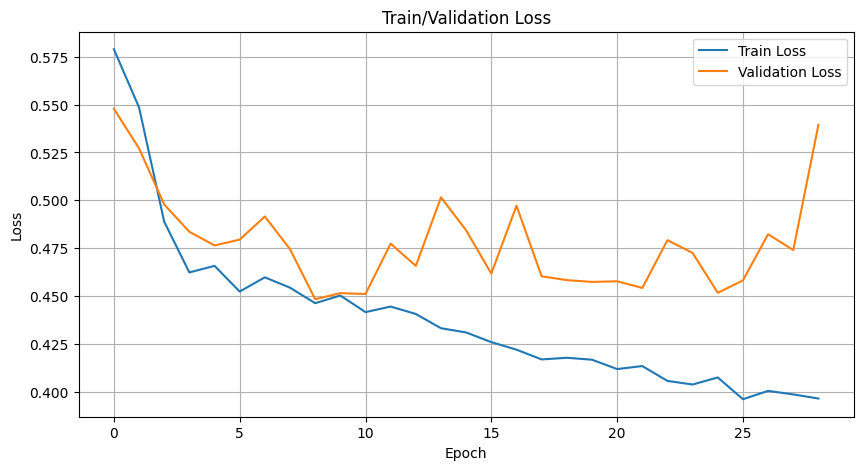

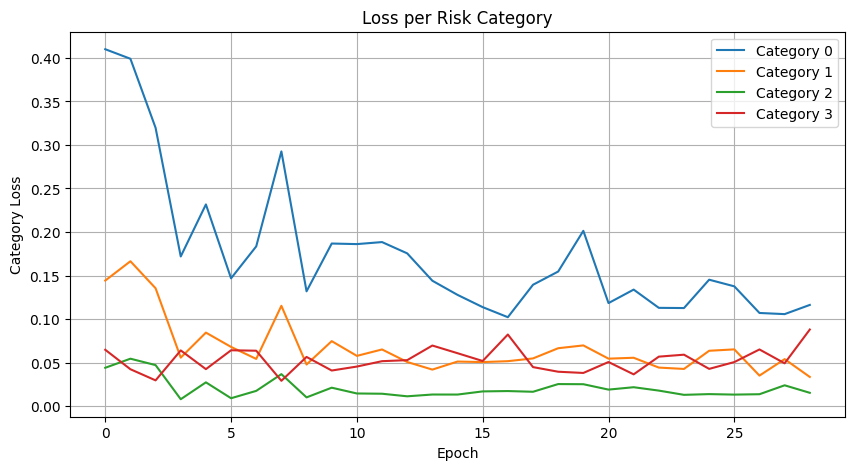

In [5]:
plot_training_history(history)

In [6]:

# best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model/best_model_ver2.pth'
# model.load_state_dict(torch.load(best_model,weights_only=True))

result = evaluate_model_on_test_set(model2, test_loader, device)

[Test] Evaluating: 100%|██████████| 29/29 [00:04<00:00,  6.83it/s]


[Test] Evaluation Summary:
  Overall Test Loss: 0.5049
  Risk Category 0: Mean Loss = 0.0905, Count = 121
  Risk Category 1: Mean Loss = 0.0305, Count = 124
  Risk Category 2: Mean Loss = 0.0145, Count = 108
  Risk Category 3: Mean Loss = 0.0791, Count = 108


In [4]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

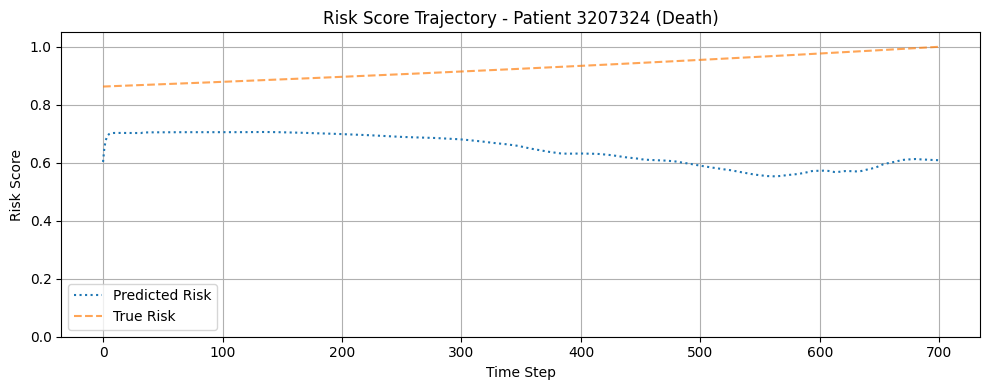

In [12]:
plot_patient_risk_trajectory(model2, test_loader, patient_index=400, device=device)

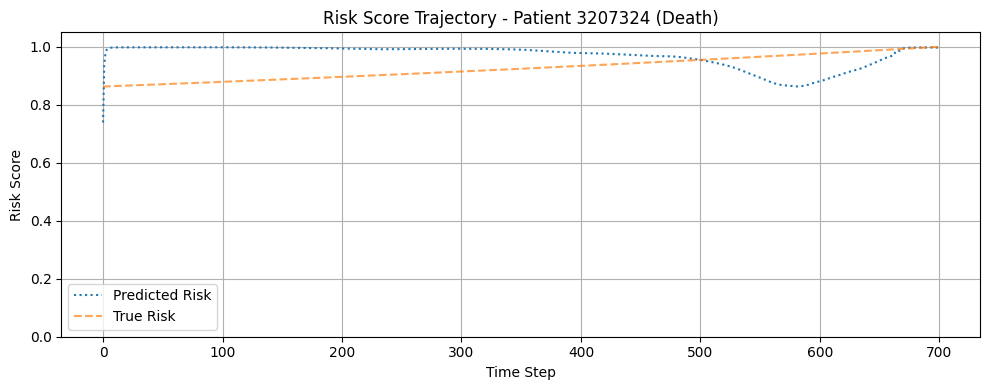

In [ ]:
plot_patient_risk_trajectory(model, test_loader, patient_index=400, device=device)

[[0.45926962 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.49451879]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.59320069 0.         0.        ]
 [0.         0.         0.         0.         0.         0.81691341
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.27112415
  0.47630965 0.43065801 0.         0.         0.         0.        ]
 [0.         0.30755241 0.         0.         0.         0.
  0.         0.      

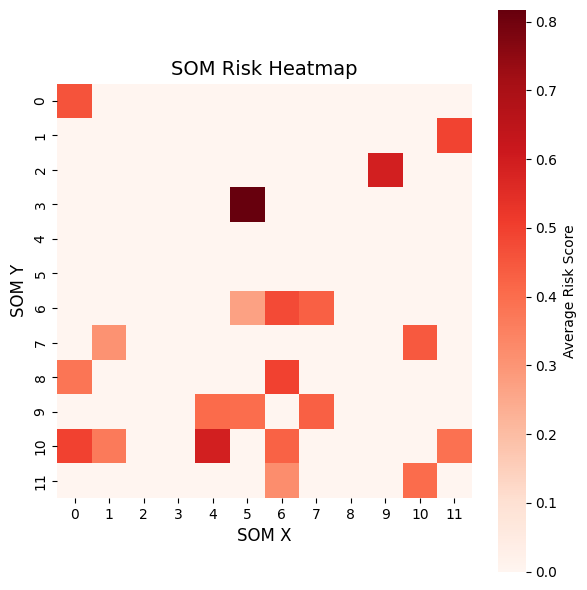

In [4]:

best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model/best_model_ver2.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))


k_list, risk_list = collect_k_and_risk_from_model(
    model=model,
    loader=train_loader,
    device=device,
    som_grid=(12, 12)
)
plot_som_risk_heatmap(k_list, risk_list, som_grid=(12, 12), title="SOM Risk Heatmap")

In [9]:
def plot_patient_trajectory(
    all_k, all_risk, patient_idx, som_grid=(12,12), cmap="YlOrRd",
):
    H, W = som_grid
    P = len(all_k)
    assert 0 <= patient_idx < P

    # 先把所有 Tensor 转成 numpy
    k_list = []
    for k_xy in all_k:
        if isinstance(k_xy, torch.Tensor):
            k_list.append(k_xy.cpu().numpy())
        else:
            k_list.append(k_xy)
    risk_list = []
    for r in all_risk:
        if isinstance(r, torch.Tensor):
            risk_list.append(r.cpu().numpy())
        else:
            risk_list.append(r)
    
    # 替换
    all_k = k_list
    all_risk = risk_list

    # —— 后面和之前一模一样 —— #
    # 1) 计算背景热图
    sum_flat = np.zeros(H*W, dtype=float)
    cnt_flat = np.zeros(H*W, dtype=int)
    for k_xy, risk_seq in zip(all_k, all_risk):
        xs = k_xy[:,0].astype(int)
        ys = k_xy[:,1].astype(int)
        flat = ys * W + xs
        for idx, rv in zip(flat, risk_seq):
            sum_flat[idx] += rv
            cnt_flat[idx] += 1

    avg_flat = np.zeros_like(sum_flat)
    nz = cnt_flat>0
    avg_flat[nz] = sum_flat[nz] / cnt_flat[nz]
    heatmap = avg_flat.reshape(H, W)

    # 2) 取出目标患者轨迹
    k_xy = all_k[patient_idx]
    xs = k_xy[:,0].astype(int)
    ys = k_xy[:,1].astype(int)
    
    # 3) 画图
    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(heatmap, cmap=cmap, square=True,
                cbar_kws={"label":"Avg Risk"}, ax=ax,
                linewidths=0.5, linecolor="gray")
    ax.plot(xs+0.5, ys+0.5, color="red", linewidth=2, zorder=2)
    ax.scatter(xs[0]+0.5, ys[0]+0.5,
               s=150, c="green", marker="o", label="Start", zorder=3)
    ax.scatter(xs[-1]+0.5, ys[-1]+0.5,
               s=150, c="red", marker="X", label="End", zorder=3)
    ax.invert_yaxis()
    ax.set_title(f"Patient {patient_idx} Trajectory")
    ax.axis("off")
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

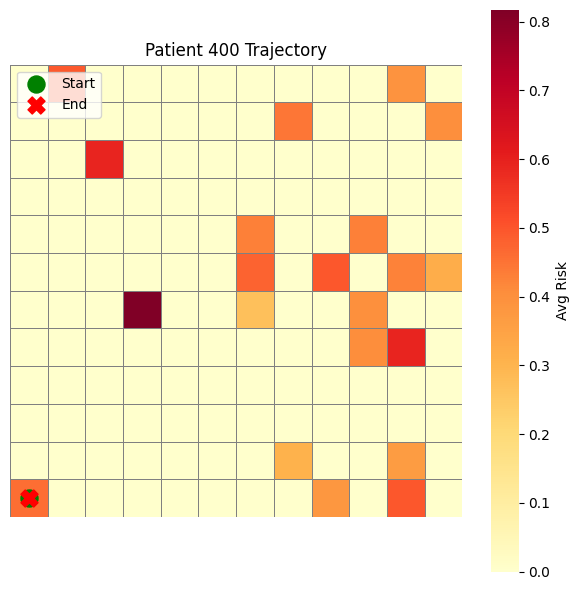

In [10]:
plot_patient_trajectory(
    all_k=k_list,
    all_risk=risk_list,
    patient_idx=400,
    som_grid=(12, 12),
    cmap="YlOrRd",
)

In [15]:
def extract_bmu(loader, model, device):
    model.eval()
    all_bmus = {}
    with torch.no_grad():
        for batch in loader:
            patient_ids, flat_data, ts_data, graph_data,risk_data, lengths, _,_ = batch
            flat_data, ts_data, lengths = flat_data.to(device), ts_data.to(device), lengths.to(device)
            patient_ids = [int(pid) for pid in patient_ids]

            # === 模型前向 ===
            risk_pred, _, som_z, aux_info,mortality_prob, _,_ = model(flat_data, graph_data, ts_data, lengths)
            
            bmus = aux_info['bmu_indices'].cpu().numpy()
            for pid, seq in zip(patient_ids, bmus):
                all_bmus[int(pid)] = seq
    return all_bmus


def plot_trajectory(bmu_seq, som_grid, cluster_stat=None):
    H, W = som_grid
    heat = np.zeros((H, W)) if cluster_stat is None else np.array(cluster_stat).reshape(H, W)
    i = bmu_seq // W
    j = bmu_seq % W
    plt.figure(figsize=(5,5))
    sns.heatmap(heat, cmap="YlGnBu", square=True, cbar=cluster_stat is not None)
    plt.plot(j+0.5, i+0.5, '-o', color='red', lw=2)
    plt.scatter(j[0]+0.5, i[0]+0.5, c='green', s=100, label='Start')
    plt.scatter(j[-1]+0.5, i[-1]+0.5, c='black', s=100, marker='X', label='End')
    plt.legend(); plt.show()


In [17]:
def extract_bmu(loader, model, device):
    """
    只使用时序分支抽取 BMU 序列：
    1) 用 ts_encoder 得到 z_e
    2) 用 som_layer 得到 bmu_indices
    """
    model.eval()
    all_bmus = {}
    with torch.no_grad():
        for batch in loader:
            patient_ids, flat_data, ts_data, graph_data,risk_data, lengths, _,_ = batch
            flat_data, ts_data, lengths = flat_data.to(device), ts_data.to(device), lengths.to(device)
            patient_ids = [int(pid) for pid in patient_ids]

            # 1) 获取原始 encoder 输出
            z_e = model.ts_encoder(ts_data, lengths)
            # 2) 只用 SOM 层获取 bmu_indices
            _, aux_info = model.som_layer(z_e)
            bmus = aux_info['bmu_indices'].cpu().numpy()  # (B, T)
            for pid, seq in zip(patient_ids, bmus):
                all_bmus[int(pid)] = seq
    return all_bmus


def plot_trajectory(bmu_seq, som_grid, cluster_stat=None):
    H, W = som_grid
    # 如果 cluster_stat 给定，reshape 成 (H,W)
    if cluster_stat is not None:
        heat = np.array(cluster_stat).reshape(H, W)
    else:
        heat = np.zeros((H, W))
    i = bmu_seq // W
    j = bmu_seq % W

    plt.figure(figsize=(5,5))
    sns.heatmap(heat, cmap="YlGnBu", square=True, cbar=cluster_stat is not None)
    # 轨迹连线
    plt.plot(j+0.5, i+0.5, '-o', color='red', lw=2)
    plt.scatter(j[0]+0.5, i[0]+0.5, c='green', s=100, label='Start')
    plt.scatter(j[-1]+0.5, i[-1]+0.5, c='black', s=100, marker='X', label='End')
    plt.legend()
    plt.show()

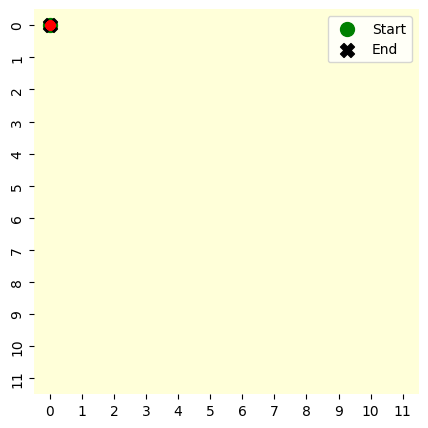

In [18]:
all_bmus = extract_bmu(train_loader, model, device='cuda')
pid = next(iter(all_bmus))
plot_trajectory(all_bmus[pid], som_grid=(12,12), cluster_stat=None)

In [21]:
print(all_bmus[0,:10])

TypeError: unhashable type: 'slice'

In [22]:
def extract_bmu(loader, model, device):
    """
    只使用时序分支抽取 BMU 序列：
    1) 用 ts_encoder 得到 z_e
    2) 用 som_layer 得到 bmu_indices
    """
    model.eval()
    all_bmus = {}
    with torch.no_grad():
        for batch in loader:
            patient_ids, flat_data, ts_data, graph_data,risk_data, lengths, _,_ = batch
            flat_data, ts_data, lengths = flat_data.to(device), ts_data.to(device), lengths.to(device)
            patient_ids = [int(pid) for pid in patient_ids]

            # 1) 获取原始 encoder 输出
            z_e = model.ts_encoder(ts_data, lengths)
            # 2) 只用 SOM 层获取 bmu_indices
            _, aux_info = model.som_layer(z_e)
            print(aux_info['bmu_indices'][0,:10])
            break 
    return all_bmus

In [23]:
extract_bmu(train_loader, model, device='cuda')

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


{}